## Adapted from Victor Zhou's CNN published at [this blog post](https://victorzhou.com/blog/keras-cnn-tutorial/).

In [10]:
import math
import mnist
import numpy as np
import time

# Using tf.keras for Ghost Batch Norm capability.
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import LearningRateScheduler, Callback
from tensorflow.keras.optimizers import Nadam

import tensorflow as tf
#print(tf.version)
# Disable INFO and WARNING messages from TensorFlow.
# Our Keras version (2.2.4 / TF 1.15.0) throws deprecation warnings.
tf.logging.set_verbosity(tf.logging.ERROR)

In [11]:
train_images = mnist.train_images() 
train_labels = mnist.train_labels()
test_images = mnist.test_images()
test_labels = mnist.test_labels()

# Normalize the images.
train_images = (train_images / 255) - 0.5
test_images = (test_images / 255) - 0.5

# Reshape the images.
train_images = np.expand_dims(train_images, axis=3)
test_images = np.expand_dims(test_images, axis=3)

num_filters = 8
filter_size = 3
pool_size = 2

In [12]:
# Build the model.
batch_size = 100       # TODO: make this less arbitrary.
ghost_batch_size = 10  # TODO: make this less arbitrary.

model = Sequential([
    # The authors required ghost batch normalization in their experiments.
    # The papers they reference use normalization preceding each convolutional layer.
    BatchNormalization(virtual_batch_size=ghost_batch_size),
    Conv2D(filters=num_filters, kernel_size=filter_size, input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=pool_size),
    Flatten(),
    Dense(units=10, activation='softmax'),
])

In [13]:
class TimeHistory(Callback):
    def on_train_begin(self, logs={}):
        self.time = 0

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.time += time.time() - self.epoch_time_start

In [14]:
# Adapted from https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/
def step_lr_decay(epoch):
    # This starts with a learning rate higher than the default learning rate in
    # Vanilla SGD. It drops by a factor of 5 each step, and I chose to drop after
    # every other epoch to make training not take too long on a laptop.
    # Think of this as a half-life equation.
    initial_lrate=0.15
    drop=0.2
    epochs_drop=2.0
    current_rate = initial_lrate * math.pow(drop, math.floor(epoch / epochs_drop))
    print("Epoch %d learning rate: %f" % (epoch + 1, current_rate))
    return current_rate

In [15]:
# Compile the model.
epochs = 6            # Run enough epochs to test the training schedule.
learning_rate = 0.00  # Will be overrided by the scheduler.
decay_rate = 0.00     # Default decay rate.
momentum = 0.0        # Default momentum.

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

model.compile(
    optimizer=sgd,  # Vanilla SGD experiment.
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

## Experiment 1: Vanilla SGD, decaying learning rate.

In [25]:
# Train the model.
decay_lr_scheduler = LearningRateScheduler(step_lr_decay)
time_callback = TimeHistory()

exp1_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(test_images, to_categorical(test_labels)),
    callbacks=[decay_lr_scheduler, time_callback]
)

Train on 60000 samples, validate on 10000 samples
Epoch 1 learning rate: 0.150000
Epoch 1/6
60000/60000 [==============================] - 6s 103us/sample - loss: 0.0674 - acc: 0.9784 - val_loss: 0.0983 - val_acc: 0.9716
Epoch 2 learning rate: 0.150000
Epoch 2/6
60000/60000 [==============================] - 6s 103us/sample - loss: 0.0596 - acc: 0.9813 - val_loss: 0.1030 - val_acc: 0.9680
Epoch 3 learning rate: 0.030000
Epoch 3/6
60000/60000 [==============================] - 6s 102us/sample - loss: 0.0393 - acc: 0.9883 - val_loss: 0.0703 - val_acc: 0.9777
Epoch 4 learning rate: 0.030000
Epoch 4/6
60000/60000 [==============================] - 6s 102us/sample - loss: 0.0357 - acc: 0.9892 - val_loss: 0.0710 - val_acc: 0.9782
Epoch 5 learning rate: 0.006000
Epoch 5/6
60000/60000 [==============================] - 6s 103us/sample - loss: 0.0309 - acc: 0.9913 - val_loss: 0.0714 - val_acc: 0.9790
Epoch 6 learning rate: 0.006000
Epoch 6/6
60000/60000 [==============================] - 6s 103

In [29]:
print(exp1_results.history)
print("")
print(time_callback.time)
times = []
times.append(time_callback.time)

{'loss': [0.06736787345260381, 0.05963184365537018, 0.039347675731793666, 0.035670843080539874, 0.030855697980732656, 0.030605852184817196], 'acc': [0.9783667, 0.9812667, 0.98833334, 0.9891667, 0.9913333, 0.99151665], 'val_loss': [0.09833866209723055, 0.1029838312510401, 0.07025660925079137, 0.07104017056524753, 0.07137862604577094, 0.07156287543708459], 'val_acc': [0.9716, 0.968, 0.9777, 0.9782, 0.979, 0.9786], 'lr': [0.15, 0.15, 0.03, 0.03, 0.006, 0.006]}

36.933000326156616


## Experiment 2: Vanilla SGD, increasing batch size.

In [30]:
# Keras has no built in for this. 
# Code is from https://www.codementor.io/nitinsurya/how-to-re-initialize-keras-model-weights-et41zre2g
def reset_weights(model):
    session = K.get_session()
    for layer in model.layers: 
        if hasattr(layer, 'kernel_initializer'):
            layer.kernel.initializer.run(session=session)

In [33]:
reset_weights(model)
learning_rate = 0.07  # Set a new constant.
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

model.compile(
    optimizer=sgd,  # Vanilla SGD experiment.
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# Just run each step independently. Keras has no callback for this.
exp2_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=2,
    batch_size=batch_size,
    validation_data=(test_images, to_categorical(test_labels)),
    callbacks=[time_callback]
)
time_tmp = time_callback.time
print(time_tmp)
tmp_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=2,
    batch_size=batch_size * 5,
    validation_data=(test_images, to_categorical(test_labels)),
    callbacks=[time_callback]
)
time_tmp += time_callback.time
print(time_tmp)

for i in tmp_results.history.keys():
    exp2_results.history[i].extend(tmp_results.history[i])

tmp_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=2,
    batch_size=batch_size * 25,
    validation_data=(test_images, to_categorical(test_labels)),
    callbacks=[time_callback]
)
time_tmp += time_callback.time
print(time_tmp)

for i in tmp_results.history.keys():
    exp2_results.history[i].extend(tmp_results.history[i])


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 6s 103us/sample - loss: 0.2594 - acc: 0.9236 - val_loss: 0.1388 - val_acc: 0.9596
Epoch 2/2
60000/60000 [==============================] - 6s 102us/sample - loss: 0.1206 - acc: 0.9644 - val_loss: 0.0994 - val_acc: 0.9701
12.291000127792358
Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 6s 94us/sample - loss: 0.0808 - acc: 0.9769 - val_loss: 0.0861 - val_acc: 0.9729
Epoch 2/2
60000/60000 [==============================] - 6s 94us/sample - loss: 0.0747 - acc: 0.9788 - val_loss: 0.0795 - val_acc: 0.9741
23.546000003814697
Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 5s 82us/sample - loss: 0.0676 - acc: 0.9811 - val_loss: 0.0788 - val_acc: 0.9752
Epoch 2/2
60000/60000 [==============================] - 5s 82us/sample - loss: 0.0668 - acc: 0.9812 - val_loss: 0.0783 

In [34]:
print(exp2_results.history)
times.append(time_tmp)
print(times)

{'loss': [0.25940101977437735, 0.12063700237311423, 0.08075917527700464, 0.07468590950593353, 0.06763385810578863, 0.06677304627373815], 'acc': [0.9236, 0.9644167, 0.9769167, 0.9788, 0.98106664, 0.98125], 'val_loss': [0.13878992691636086, 0.09938671678304672, 0.08610570803284645, 0.07953261733055114, 0.07882767356932163, 0.07834860309958458], 'val_acc': [0.9596, 0.9701, 0.9729, 0.9741, 0.9752, 0.9746]}
[36.933000326156616, 33.39100003242493]


## Experiment 3: Vanilla SGD, hybrid.

In [35]:
def hybrid_lr_decay(epoch):
    # Start off from the constant learning rate from the hybrid's initialization.
    initial_lrate=0.05
    drop=0.2
    epochs_drop=2.0
    current_rate = initial_lrate * math.pow(drop, math.floor(epoch / epochs_drop))
    print("Epoch %d learning rate: %f" % (epoch + 1, current_rate))
    return current_rate

hybrid_lr_scheduler = LearningRateScheduler(hybrid_lr_decay)

In [36]:
reset_weights(model)
learning_rate = 0.05  # Set a new constant.
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

model.compile(
    optimizer=sgd,  # Vanilla SGD experiment.
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# Run a step, and then increase the batch size manually. The decay scheduler
# will decay the learning rate in the next step.
exp3_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=2,
    batch_size=batch_size,
    validation_data=(test_images, to_categorical(test_labels)),
    callbacks=[time_callback]
)
time_tmp = time_callback.time

tmp_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=4,
    batch_size=batch_size * 5,
    validation_data=(test_images, to_categorical(test_labels)),
    callbacks=[hybrid_lr_scheduler, time_callback]
)
time_tmp += time_callback.time

for i in tmp_results.history.keys():
    if i == 'lr':
        continue
    exp3_results.history[i].extend(tmp_results.history[i])

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 6s 104us/sample - loss: 0.2759 - acc: 0.9194 - val_loss: 0.1402 - val_acc: 0.9578
Epoch 2/2
60000/60000 [==============================] - 6s 103us/sample - loss: 0.1209 - acc: 0.9647 - val_loss: 0.1020 - val_acc: 0.9674
Train on 60000 samples, validate on 10000 samples
Epoch 1 learning rate: 0.050000
Epoch 1/4
60000/60000 [==============================] - 6s 93us/sample - loss: 0.0838 - acc: 0.9756 - val_loss: 0.0833 - val_acc: 0.9740
Epoch 2 learning rate: 0.050000
Epoch 2/4
60000/60000 [==============================] - 6s 95us/sample - loss: 0.0774 - acc: 0.9771 - val_loss: 0.0805 - val_acc: 0.9739
Epoch 3 learning rate: 0.010000
Epoch 3/4
60000/60000 [==============================] - 6s 94us/sample - loss: 0.0712 - acc: 0.9793 - val_loss: 0.0793 - val_acc: 0.9745
Epoch 4 learning rate: 0.010000
Epoch 4/4
60000/60000 [==============================] - 6s 94us/sample - loss: 

In [37]:
print(exp3_results.history)
times.append(time_tmp)
print(times)

{'loss': [0.2758980800708135, 0.12094662707919876, 0.08379201954230667, 0.0773597170598805, 0.07122731988007823, 0.07055117593457301], 'acc': [0.91936666, 0.9647167, 0.9756, 0.9770833, 0.97933334, 0.9796], 'val_loss': [0.14016003973782062, 0.102014246173203, 0.08332923036068678, 0.0804838091135025, 0.07929230704903603, 0.07885571736842394], 'val_acc': [0.9578, 0.9674, 0.974, 0.9739, 0.9745, 0.9741]}
[36.933000326156616, 33.39100003242493, 35.02800011634827]


## Experiment 4: Adam, decaying learning rate

In [38]:
'''
# Adapted from https://machinelearningmastery.com/using-learning-rate-schedules-deep-learning-models-python-keras/
def step_lr_decay_adam(epoch):
    # Same learning-rate decaying algorithm as Vanilla SGD, except setting the initial rate to 0.001
    initial_lrate=0.001
    drop=0.2
    epochs_drop=2.0
    current_rate = initial_lrate * math.pow(drop, math.floor(epoch / epochs_drop))
    print("Epoch %d learning rate: %f" % (epoch + 1, current_rate))
    return current_rate
'''
reset_weights(model)
nadam = Nadam() #The paper uses the default settings for Adam

model.compile(
    optimizer=nadam,  # Adam experiment.
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# Train the model.
decay_lr_scheduler = LearningRateScheduler(step_lr_decay)

exp4_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(test_images, to_categorical(test_labels)),
    callbacks=[decay_lr_scheduler, time_callback]
)

Train on 60000 samples, validate on 10000 samples
Epoch 1 learning rate: 0.150000
Epoch 1/6
60000/60000 [==============================] - 6s 106us/sample - loss: 1.2920 - acc: 0.9180 - val_loss: 0.1324 - val_acc: 0.9610
Epoch 2 learning rate: 0.150000
Epoch 2/6
60000/60000 [==============================] - 6s 104us/sample - loss: 0.1292 - acc: 0.9618 - val_loss: 0.1121 - val_acc: 0.9651
Epoch 3 learning rate: 0.030000
Epoch 3/6
60000/60000 [==============================] - 6s 105us/sample - loss: 0.0729 - acc: 0.9785 - val_loss: 0.0804 - val_acc: 0.9754
Epoch 4 learning rate: 0.030000
Epoch 4/6
60000/60000 [==============================] - 6s 104us/sample - loss: 0.0654 - acc: 0.9803 - val_loss: 0.0839 - val_acc: 0.9738
Epoch 5 learning rate: 0.006000
Epoch 5/6
60000/60000 [==============================] - 6s 104us/sample - loss: 0.0485 - acc: 0.9853 - val_loss: 0.0752 - val_acc: 0.9766
Epoch 6 learning rate: 0.006000
Epoch 6/6
60000/60000 [==============================] - 6s 105

In [39]:
print(exp4_results.history)
times.append(time_callback.time)
print(times)

{'loss': [1.2920175444583097, 0.12920907703849177, 0.07288842842332087, 0.06537625825963915, 0.04854224285343662, 0.045723953620763494], 'acc': [0.918, 0.96181667, 0.9784667, 0.9802833, 0.9853, 0.9858], 'val_loss': [0.13237396851181985, 0.11212772453203797, 0.0803924743179232, 0.08392652725800871, 0.07523445009253919, 0.0772659906418994], 'val_acc': [0.961, 0.9651, 0.9754, 0.9738, 0.9766, 0.9763], 'lr': [0.15, 0.15, 0.03, 0.03, 0.006, 0.006]}
[36.933000326156616, 33.39100003242493, 35.02800011634827, 37.67700004577637]


## Experiment 5: Adam, increasing batch size.

In [40]:
reset_weights(model)
nadam = Nadam() #The paper uses the default settings for Adam

model.compile(
    optimizer=nadam,  # Adam experiment.
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# Just run each step independently. Keras has no callback for this.
exp5_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=2,
    batch_size=batch_size,
    validation_data=(test_images, to_categorical(test_labels)),
    callbacks=[time_callback]
)
time_tmp = time_callback.time
tmp_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=2,
    batch_size=batch_size * 5,
    validation_data=(test_images, to_categorical(test_labels)),
    callbacks=[time_callback]
)
time_tmp += time_callback.time

for i in tmp_results.history.keys():
    exp5_results.history[i].extend(tmp_results.history[i])

tmp_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=2,
    batch_size=batch_size * 25,
    validation_data=(test_images, to_categorical(test_labels)),
    callbacks=[time_callback]
)
time_tmp += time_callback.time

for i in tmp_results.history.keys():
    exp5_results.history[i].extend(tmp_results.history[i])

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 6s 107us/sample - loss: 0.4960 - acc: 0.8613 - val_loss: 0.2642 - val_acc: 0.9237
Epoch 2/2
60000/60000 [==============================] - 6s 105us/sample - loss: 0.2257 - acc: 0.9350 - val_loss: 0.1733 - val_acc: 0.9478
Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 6s 95us/sample - loss: 0.1642 - acc: 0.9537 - val_loss: 0.1515 - val_acc: 0.9542
Epoch 2/2
60000/60000 [==============================] - 6s 96us/sample - loss: 0.1503 - acc: 0.9579 - val_loss: 0.1417 - val_acc: 0.9581
Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 5s 83us/sample - loss: 0.1415 - acc: 0.9604 - val_loss: 0.1385 - val_acc: 0.9590
Epoch 2/2
60000/60000 [==============================] - 5s 83us/sample - loss: 0.1391 - acc: 0.9608 - val_loss: 0.1364 - val_acc: 0.9599


In [41]:
print(exp5_results.history)
times.append(time_tmp)
print(times)

{'loss': [0.49604139372706413, 0.22570454211284716, 0.16415221896022558, 0.15032457125683626, 0.14152068737894297, 0.1391244282325109], 'acc': [0.86135, 0.9350333, 0.9537, 0.95786667, 0.9604, 0.9608167], 'val_loss': [0.2641504350304604, 0.17333052691072226, 0.15154593661427498, 0.14173746146261693, 0.13854317739605904, 0.13640664890408516], 'val_acc': [0.9237, 0.9478, 0.9542, 0.9581, 0.959, 0.9599]}
[36.933000326156616, 33.39100003242493, 35.02800011634827, 37.67700004577637, 34.20099997520447]


## Experiment 6: Adam, hybrid.

In [42]:
def hybrid_lr_decay_adam(epoch):
    # Start off from the constant learning rate from the hybrid's initialization.
    initial_lrate=0.001 #initial learning rate for Adam's Keras's default = 0.001
    drop=0.2
    epochs_drop=2.0
    current_rate = initial_lrate * math.pow(drop, math.floor(epoch / epochs_drop))
    print("Epoch %d learning rate: %f" % (epoch + 1, current_rate))
    return current_rate

hybrid_lr_scheduler_adam = LearningRateScheduler(hybrid_lr_decay_adam)

In [44]:
reset_weights(model)
nadam = Nadam() #The paper uses the default settings for Adam

model.compile(
    optimizer=nadam,  # Adam experiment.
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# Run a step, and then increase the batch size manually. The decay scheduler
# will decay the learning rate in the next step.
exp6_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=2,
    batch_size=batch_size,
    validation_data=(test_images, to_categorical(test_labels)),
    callbacks=[time_callback]
)
time_tmp = time_callback.time

tmp_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=4,
    batch_size=batch_size * 5,
    validation_data=(test_images, to_categorical(test_labels)),
    callbacks=[hybrid_lr_scheduler_adam, time_callback]
)
time_tmp += time_callback.time

for i in tmp_results.history.keys():
    if i == 'lr':
        continue
    exp6_results.history[i].extend(tmp_results.history[i])

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 7s 110us/sample - loss: 0.4097 - acc: 0.8853 - val_loss: 0.2011 - val_acc: 0.9405
Epoch 2/2
60000/60000 [==============================] - 6s 104us/sample - loss: 0.1733 - acc: 0.9500 - val_loss: 0.1384 - val_acc: 0.9573
Train on 60000 samples, validate on 10000 samples
Epoch 1 learning rate: 0.001000
Epoch 1/4
60000/60000 [==============================] - 6s 95us/sample - loss: 0.1231 - acc: 0.9657 - val_loss: 0.1237 - val_acc: 0.9635
Epoch 2 learning rate: 0.001000
Epoch 2/4
60000/60000 [==============================] - 6s 96us/sample - loss: 0.1130 - acc: 0.9689 - val_loss: 0.1158 - val_acc: 0.9667
Epoch 3 learning rate: 0.000200
Epoch 3/4
60000/60000 [==============================] - 6s 95us/sample - loss: 0.1050 - acc: 0.9711 - val_loss: 0.1125 - val_acc: 0.9670
Epoch 4 learning rate: 0.000200
Epoch 4/4
60000/60000 [==============================] - 6s 96us/sample - loss: 

In [45]:
print(exp6_results.history)
times.append(time_tmp)
print(times)

{'loss': [0.40972773731996615, 0.17325412718579172, 0.12309712941447894, 0.11298203816016515, 0.10497715336581072, 0.10272361508881052], 'acc': [0.88526666, 0.94996667, 0.96565, 0.96895, 0.97115, 0.9715], 'val_loss': [0.20114876329898834, 0.13836864702403545, 0.1236868727952242, 0.11576697416603565, 0.1124572141095996, 0.11134538650512696], 'val_acc': [0.9405, 0.9573, 0.9635, 0.9667, 0.967, 0.9678]}
[36.933000326156616, 33.39100003242493, 35.02800011634827, 37.67700004577637, 34.20099997520447, 35.74000000953674]


## Experiment 7: SGD with momentum, decaying learning rate.

In [46]:
reset_weights(model)
learning_rate = 0.07  # Set a new constant.
momentum = 0.1
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=True)

model.compile(
    optimizer=sgd,  # Vanilla SGD experiment.
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# Train the model.
decay_lr_scheduler = LearningRateScheduler(step_lr_decay)

exp7_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(test_images, to_categorical(test_labels)),
    callbacks=[decay_lr_scheduler]
)

Train on 60000 samples, validate on 10000 samples
Epoch 1 learning rate: 0.150000
Epoch 1/6
60000/60000 [==============================] - 6s 102us/sample - loss: nan - acc: 0.0994 - val_loss: nan - val_acc: 0.0980
Epoch 2 learning rate: 0.150000
Epoch 2/6
60000/60000 [==============================] - 6s 100us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Epoch 3 learning rate: 0.030000
Epoch 3/6
60000/60000 [==============================] - 6s 101us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Epoch 4 learning rate: 0.030000
Epoch 4/6
60000/60000 [==============================] - 6s 101us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Epoch 5 learning rate: 0.006000
Epoch 5/6
60000/60000 [==============================] - 6s 100us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Epoch 6 learning rate: 0.006000
Epoch 6/6
60000/60000 [==============================] - 6s 100us/sample - loss: nan - acc: 0

In [47]:
exp7_results.history

{'loss': [nan, nan, nan, nan, nan, nan],
 'acc': [0.099366665,
  0.09871667,
  0.09871667,
  0.09871667,
  0.09871667,
  0.09871667],
 'val_loss': [nan, nan, nan, nan, nan, nan],
 'val_acc': [0.098, 0.098, 0.098, 0.098, 0.098, 0.098],
 'lr': [0.15, 0.15, 0.03, 0.03, 0.006, 0.006]}

## Experiment 8: SGD with momentum, increasing batch size.

In [48]:
reset_weights(model)
momentum = 0.1
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

model.compile(
    optimizer=sgd,  # Vanilla SGD experiment.
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# Just run each step independently. Keras has no callback for this.
exp8_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=2,
    batch_size=batch_size,
    validation_data=(test_images, to_categorical(test_labels))
)
tmp_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=2,
    batch_size=batch_size * 5,
    validation_data=(test_images, to_categorical(test_labels))
)

for i in tmp_results.history.keys():
    exp8_results.history[i].extend(tmp_results.history[i])

tmp_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=2,
    batch_size=batch_size * 25,
    validation_data=(test_images, to_categorical(test_labels))
)

for i in tmp_results.history.keys():
    exp8_results.history[i].extend(tmp_results.history[i])


Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 6s 103us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Epoch 2/2
60000/60000 [==============================] - 6s 103us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 5s 91us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Epoch 2/2
60000/60000 [==============================] - 6s 93us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 5s 82us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Epoch 2/2
60000/60000 [==============================] - 5s 82us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980


In [49]:
exp8_results.history

{'loss': [nan, nan, nan, nan, nan, nan],
 'acc': [0.09871667,
  0.09871667,
  0.09871667,
  0.09871667,
  0.09871667,
  0.09871667],
 'val_loss': [nan, nan, nan, nan, nan, nan],
 'val_acc': [0.098, 0.098, 0.098, 0.098, 0.098, 0.098]}

## Experiment 9: SGD with momentum, hybrid.

In [50]:
reset_weights(model)
learning_rate = 0.05  # Set a new constant.
momentum = 0.1
sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)

model.compile(
    optimizer=sgd,  # Vanilla SGD experiment.
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)

# Run a step, and then increase the batch size manually. The decay scheduler
# will decay the learning rate in the next step.
exp9_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=2,
    batch_size=batch_size,
    validation_data=(test_images, to_categorical(test_labels))
)

tmp_results = model.fit(
    train_images,
    to_categorical(train_labels),
    epochs=4,
    batch_size=batch_size * 5,
    validation_data=(test_images, to_categorical(test_labels)),
    callbacks=[hybrid_lr_scheduler]
)

for i in tmp_results.history.keys():
    if i == 'lr':
        continue
    exp9_results.history[i].extend(tmp_results.history[i])

Train on 60000 samples, validate on 10000 samples
Epoch 1/2
60000/60000 [==============================] - 6s 102us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Epoch 2/2
60000/60000 [==============================] - 6s 99us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Train on 60000 samples, validate on 10000 samples
Epoch 1 learning rate: 0.050000
Epoch 1/4
60000/60000 [==============================] - 6s 94us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Epoch 2 learning rate: 0.050000
Epoch 2/4
60000/60000 [==============================] - 6s 92us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Epoch 3 learning rate: 0.010000
Epoch 3/4
60000/60000 [==============================] - 6s 93us/sample - loss: nan - acc: 0.0987 - val_loss: nan - val_acc: 0.0980
Epoch 4 learning rate: 0.010000
Epoch 4/4
60000/60000 [==============================] - 6s 93us/sample - loss: nan - acc: 0.0987 - val_loss: n

In [51]:
exp9_results.history

{'loss': [nan, nan, nan, nan, nan, nan],
 'acc': [0.09871667,
  0.09871667,
  0.09871667,
  0.09871667,
  0.09871667,
  0.09871667],
 'val_loss': [nan, nan, nan, nan, nan, nan],
 'val_acc': [0.098, 0.098, 0.098, 0.098, 0.098, 0.098]}

## Experiment 1-3 Plots

In [52]:
import matplotlib
import matplotlib.pyplot as plt

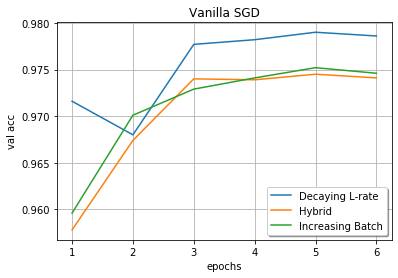

In [53]:
f_vanillasgd, a_vanillasgd = plt.subplots()
a_vanillasgd.plot(range(1,7), exp1_results.history["val_acc"], label="Decaying L-rate")
a_vanillasgd.plot(range(1,7), exp3_results.history["val_acc"], label="Hybrid")
a_vanillasgd.plot(range(1,7), exp2_results.history["val_acc"], label="Increasing Batch")

legend = a_vanillasgd.legend(loc='lower right', shadow=True, fontsize='medium')
a_vanillasgd.set(xlabel='epochs', ylabel='val acc', title='Vanilla SGD')
a_vanillasgd.grid()

f_vanillasgd.savefig("vanilla_sgd.png")

## Experiment 4-6 Plots

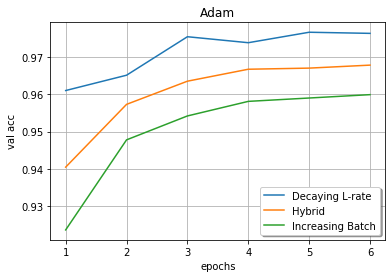

In [54]:
f_adam, a_adam = plt.subplots()
a_adam.plot(range(1,7), exp4_results.history["val_acc"], label="Decaying L-rate")
a_adam.plot(range(1,7), exp6_results.history["val_acc"], label="Hybrid")
a_adam.plot(range(1,7), exp5_results.history["val_acc"], label="Increasing Batch")

legend = a_adam.legend(loc='lower right', shadow=True, fontsize='medium')
a_adam.set(xlabel='epochs', ylabel='val acc', title='Adam')
a_adam.grid()

f_adam.savefig("adam.png")

## Experiment 7-9 Plots

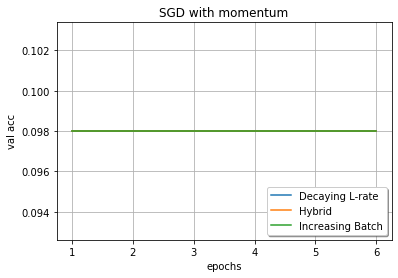

In [55]:
f_sgdm, a_sgdm = plt.subplots()
a_sgdm.plot(range(1,7), exp7_results.history["val_acc"], label="Decaying L-rate")
a_sgdm.plot(range(1,7), exp9_results.history["val_acc"], label="Hybrid")
a_sgdm.plot(range(1,7), exp8_results.history["val_acc"], label="Increasing Batch")

legend = a_sgdm.legend(loc='lower right', shadow=True, fontsize='medium')
a_sgdm.set(xlabel='epochs', ylabel='val acc', title='SGD with momentum')
a_sgdm.grid()

f_sgdm.savefig("sgd_with_momentum.png")

## Time comparison (1-3)

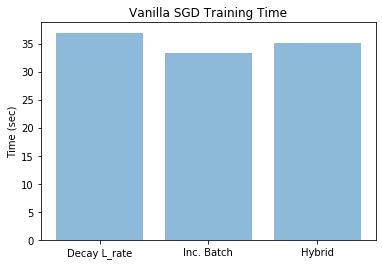

In [66]:
objects = ('Decay L_rate', 'Inc. Batch', 'Hybrid')
y_pos = np.arange(len(objects))
performance = times[0:3]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Time (sec)')
plt.title('Vanilla SGD Training Time')

plt.show()
#plt.savefig("vanillaSGD_time.png")

## Time comparison (4-6)

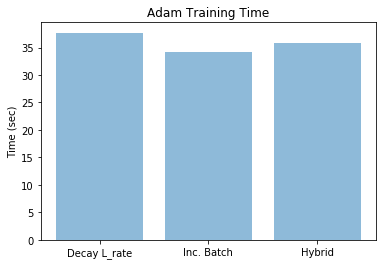

In [67]:
objects = ('Decay L_rate', 'Inc. Batch', 'Hybrid')
y_pos = np.arange(len(objects))
performance = times[3:6]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Usage')
plt.title('Programming language usage')

plt.ylabel('Time (sec)')
plt.title('Adam Training Time')

plt.show()